In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

In [2]:
data = pd.read_csv('./data/train_data_subsampled_Uautocorr_longtime.csv')

y = data['R']
X = data.drop(['R'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1966, 7]),
 torch.Size([1966, 1]),
 torch.Size([492, 7]),
 torch.Size([492, 1]))

In [26]:
batch_size = 1966
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 7)
        self.fc2 = nn.Linear(7, 3)
        self.fc3 = nn.Linear(3, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999))

# Enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

# Use mixed precision training
scaler = GradScaler()

In [27]:
# Train the model
epochs = 4000
losses = [] 
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        with autocast():
            output = model(inputs)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    if epoch % 50 == 0:  # print loss every 50 epochs
        print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/nurul/tensorflow/tensorflow/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/nurul/tensorflow/tensorflow/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/nurul/tensorflow/tensorflow/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/nurul/tensorflow/tensorflow/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 196, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/home/nurul/tensorflow/tensorflow/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 196, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



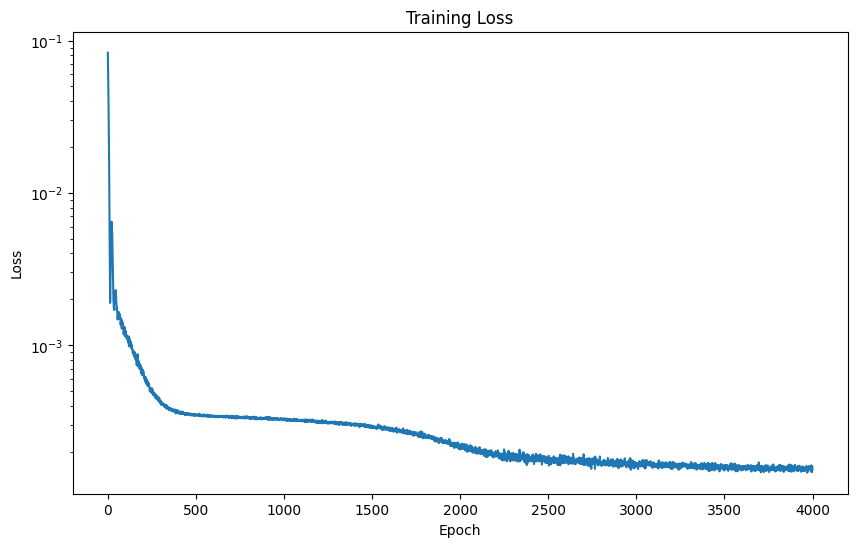

In [21]:
# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [22]:
# Test the model
model.eval()
test_loss = 0
for inputs, labels in test_loader:
    output = model(inputs)
    loss = criterion(output, labels)
    test_loss += loss.item()

print("Test loss:", test_loss)

Test loss: 0.00014505413128063083


In [23]:
# Make predictions using the trained model
model.eval()
predictions = model(X_test).detach().cpu().numpy()

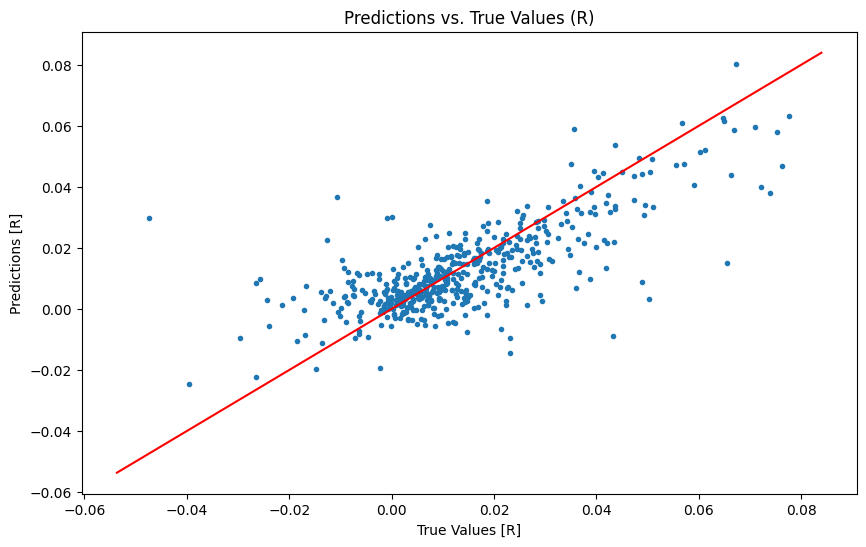

In [24]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test.cpu()).iloc[:,0], predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

plt.show()

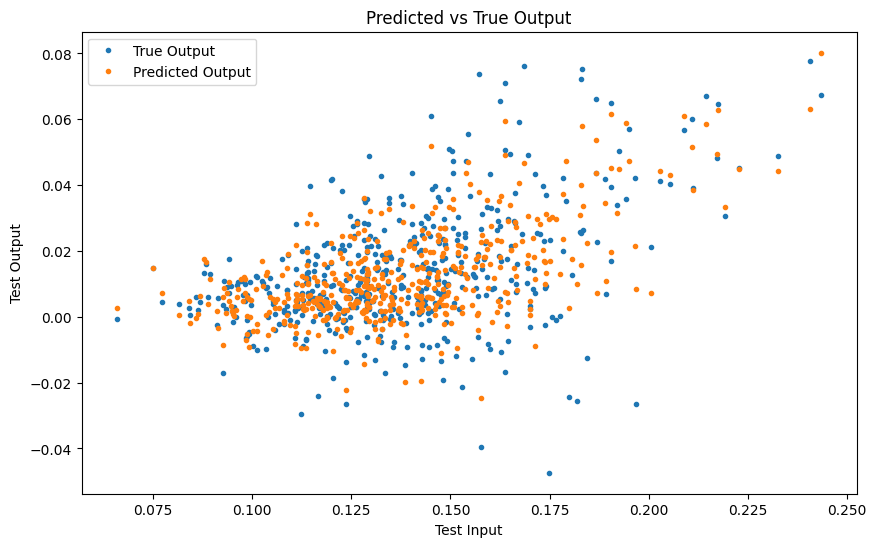

In [25]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))

# Scatter plot of True test output vs first column of Test Input
plt.plot(X_test[:, 0].cpu(), y_test.cpu(), '.', label='True Output')

# Scatter plot of Predicted output vs first column of Test Input
plt.plot(X_test[:, 0].cpu(), predictions, '.', label='Predicted Output')

plt.legend()
plt.xlabel('Test Input')
plt.ylabel('Test Output')
plt.title('Predicted vs True Output')
plt.show()